# System

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
os.getcwd()

'/content'

# Libraries

In [ ]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil

# GPU

In [ ]:
# setting device on GPU if available, else CPU
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device("cuda")
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU... Ready for HyperJump...")
else:
    device = torch.device("cpu")
    print("Training on CPU... May the force be with you...")

Training on GPU... Ready for HyperJump...


In [ ]:
torch.cuda.is_available()

True

# PATHS

In [ ]:
DATA_PATH = '/content/drive/MyDrive/chest_xray'
print("DATA_PATH = ",DATA_PATH)

TRAIN_PATH = os.path.join(DATA_PATH, "train/")
print("TRAIN_PATH = ", TRAIN_PATH)

VAL_PATH = os.path.join(DATA_PATH, "test/")
print("TEST_PATH = ",VAL_PATH)

DATA_PATH =  /content/drive/MyDrive/chest_xray
TRAIN_PATH =  /content/drive/MyDrive/chest_xray/train/
TEST_PATH =  /content/drive/MyDrive/chest_xray/test/


# Plotting Distribution of Each Classes

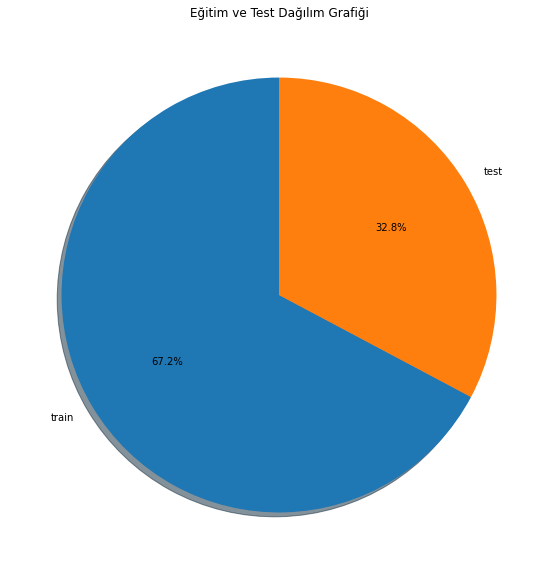

In [ ]:
# class_names = os.listdir(DATA_PATH)
class_name_train = os.listdir(TRAIN_PATH)
class_name_val = os.listdir(VAL_PATH)
image_count_train = {}
image_count_val = {}

for i in class_name_train:
    image_count_train[i] = len(os.listdir(os.path.join(TRAIN_PATH,i)))
    
for i in class_name_val:
    image_count_val[i] = len(os.listdir(os.path.join(VAL_PATH,i)))

# print(image_count_train)

sum_train_images = 0
for k,v in image_count_train.items():
    sum_train_images += v

# print(sum_train_images)

sum_val_images = 0
for k,v in image_count_val.items():
     sum_val_images += v

# print(sum_val_images)

image_count = {'train': sum_train_images, 'test': sum_val_images}

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Eğitim ve Test Dağılım Grafiği")
plt.show()


# Plotting Distribution of Train Classes

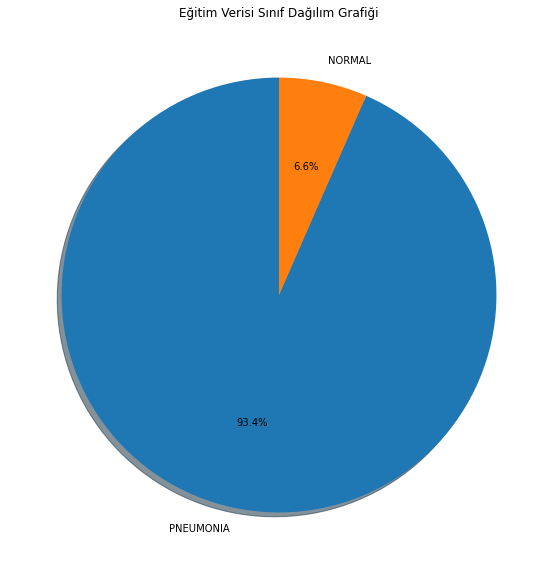

{'PNEUMONIA': 1196, 'NORMAL': 84}


In [ ]:
class_names = os.listdir(TRAIN_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(TRAIN_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Eğitim Verisi Sınıf Dağılım Grafiği")
plt.show()
print(image_count)

# Plotting Distribution of Test Classes

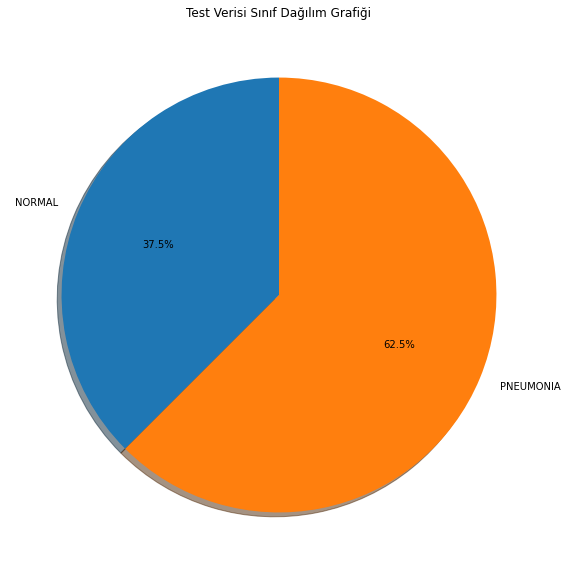

{'NORMAL': 234, 'PNEUMONIA': 390}


In [ ]:
class_names = os.listdir(VAL_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(VAL_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots(figsize=(10, 10), subplot_kw=dict(aspect="equal"))
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.title("Test Verisi Sınıf Dağılım Grafiği")
plt.show()
print(image_count)

# Data Loading

In [ ]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((224,224)), #Resizes all images into same dimension
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "test": transforms.Compose([
                                transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}


In [ ]:
def load_split_train_test(datadir, valid_size = .3):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    print(train_data)
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['test'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=16) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=16)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(TRAIN_PATH, .3)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(data_sizes)
print(class_names)

# Dataset has 15886 data points.
# Train Dataset has 12708 data points
# Test Dataset has 3178 data points.

Dataset ImageFolder
    Number of datapoints: 1280
    Root location: /content/drive/MyDrive/chest_xray/train/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
{'train': 896, 'val': 384}
['NORMAL', 'PNEUMONIA']


# Visualization of Train Samples

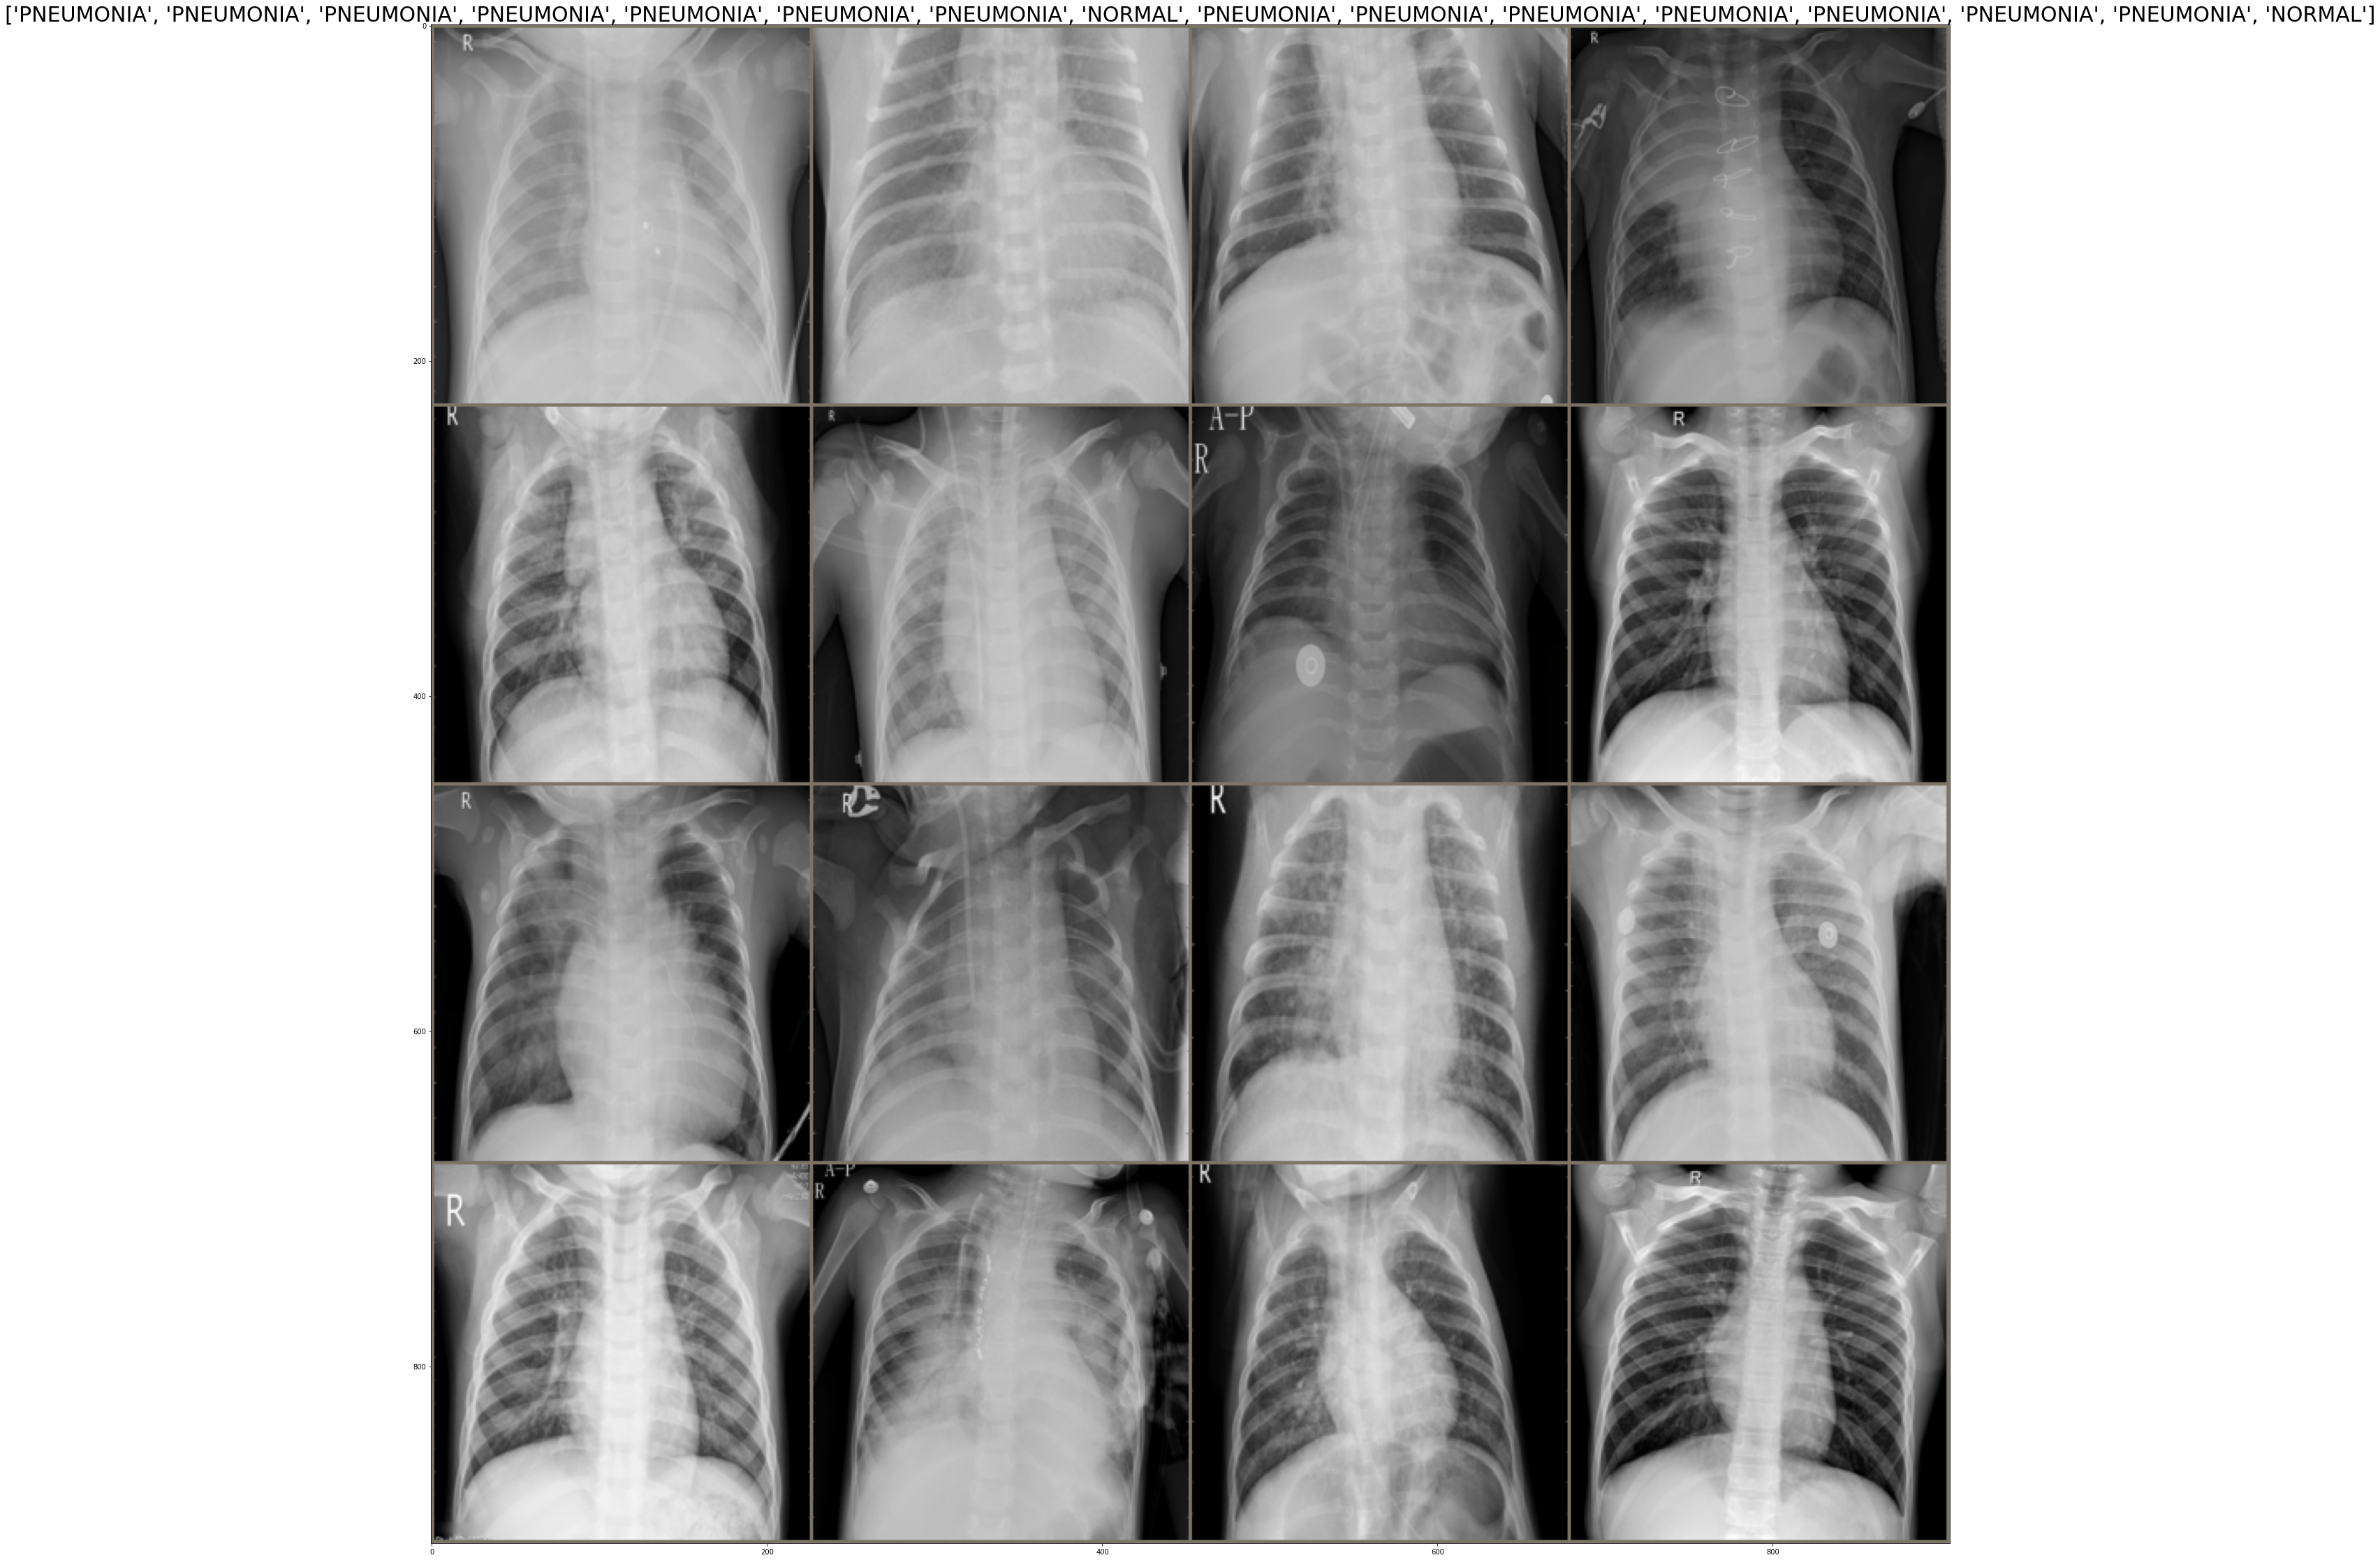

In [ ]:
import matplotlib
def imshow(inp, size =(40,40), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow =  4, padding =  2, value_range = 1)



imshow(out, title=[class_names[x] for x in classes])


# # Get a batch of val data

# inputs, classes = next(iter(dataloaders['val']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])


# All model variants

In [ ]:
def CNN_Model(pretrained=True):
    #model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    model = models.alexnet(pretrained=pretrained)
    model.eval()
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1) # Learning Scheduler

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# Training

In [ ]:
import math
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
                #print(val_kappa)
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=2)

Epoch 1/2
----------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.8821 | train Accuracy: 0.8940


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.4653 | val Accuracy: 0.9297 | Kappa Score: nan
Val loss Decreased from inf to 0.4653 
Saving Weights... 

Epoch 2/2
----------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2668 | train Accuracy: 0.9364


val:   0%|          | 0/24 [00:00<?, ?it/s]

val Loss: 0.2557 | val Accuracy: 0.9297 | Kappa Score: nan
Val loss Decreased from 0.4653 to 0.2557 
Saving Weights... 

Training complete in 1m 47s
Best val loss: 0.2557


In [ ]:
torch.save(model.state_dict(), "alexnet_chestxray.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


# Model Visualization

In [ ]:
def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} Predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (16,4))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

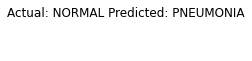

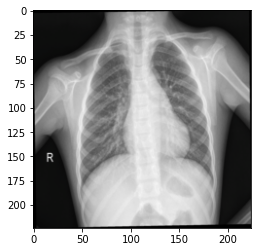

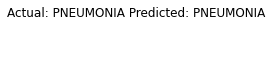

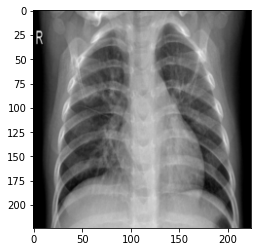

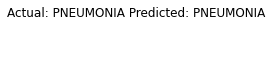

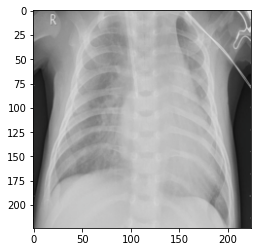

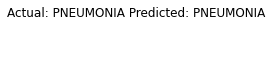

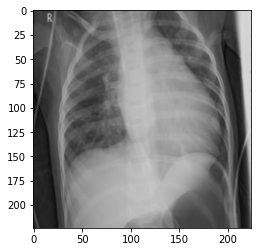

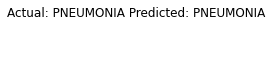

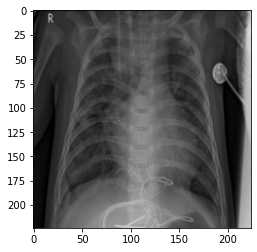

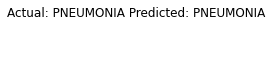

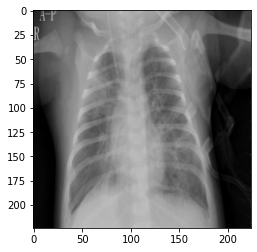

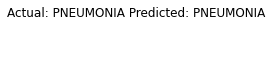

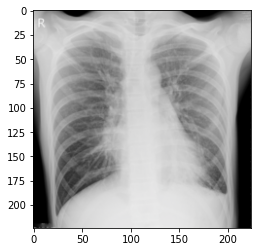

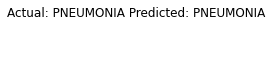

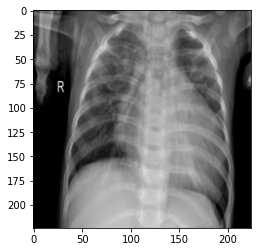

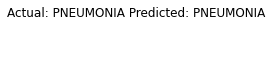

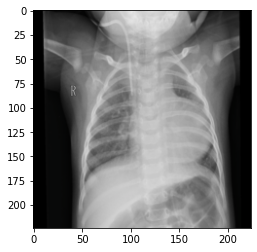

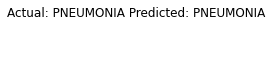

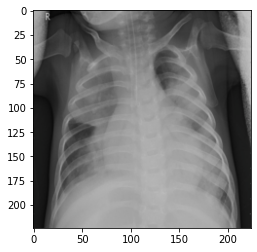

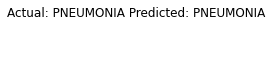

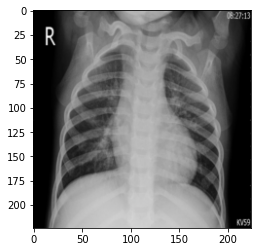

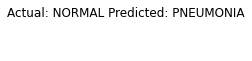

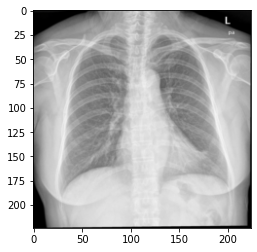

In [ ]:
visualize_model(base_model)
plt.show()

# Test Accuracy

In [ ]:
class_names

['NORMAL', 'PNEUMONIA']

In [ ]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F

def test_model(model,dataloaders,device):
    CM=0
    model.eval()
    with torch.no_grad():
        #for data in dataloaders['test']:
        i=0
        j=0
        sumtp, sumfp, sumfn, sumfp = 0, 0, 0, 0
        for data in dataloaders['val']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images) #file_name
            preds = torch.argmax(outputs.data, 1)
            CM+=confusion_matrix(labels.cpu(), preds.cpu(),labels=[0, 1 ])

        tp=CM[1][1]
        fp=CM[0][1]
        fn=CM[1][0]
        acc=np.sum(np.diag(CM)/np.sum(CM))
        recall=sumtp/(sumtp+sumfn)
        precision=sumtp/(sumtp+sumfp)
        print('\nTestset Accuracy(mean): %f %%' % (100 * acc))
        #print('- NPV: ',(tn/(tn+fn))*100
        return acc, CM

    

In [ ]:
acc, cm = test_model(model,dataloaders,device)
print(cm)
print("Accuracy",acc)

sumfn [27, 0]
fparray [0, 27]
sumfp 27
sumfn 27
sumtp 357

Testset Accuracy(mean): 92.968750 %
- Recall :  92.96875
- Precision:  92.96875
- F1 Score:  92.96875
[[  0  27]
 [  0 357]]
Accuracy 0.9296875


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
class_names

['NORMAL', 'PNEUMONIA']

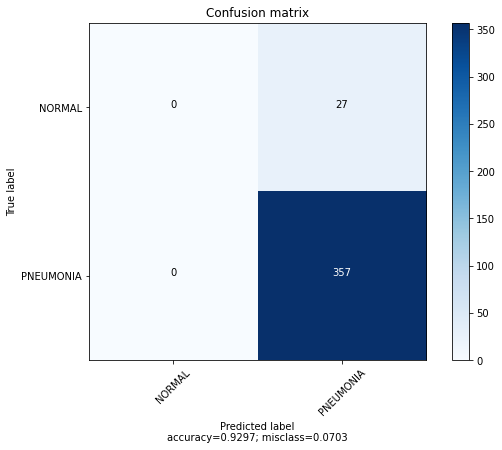

In [ ]:
from sklearn import metrics
plot_confusion_matrix(cm, target_names= ['NORMAL', 'PNEUMONIA'], title='Confusion matrix' , normalize=False)

## Real AlexNet optimizer values

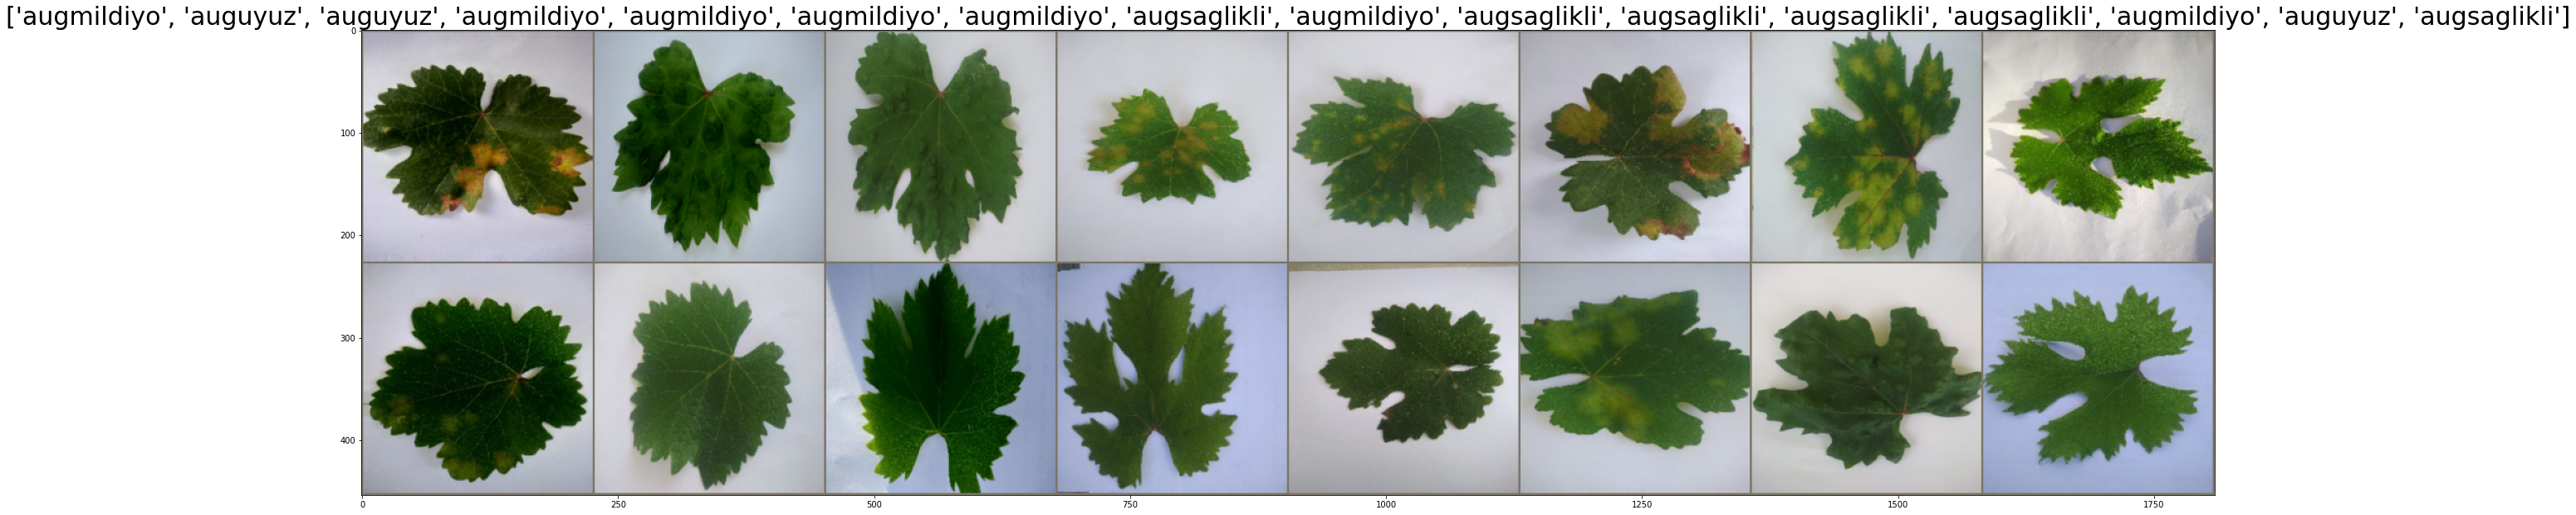

In [ ]:
import matplotlib
def imshow(inp, size =(40,40), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data

inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow =  8, padding =  2, value_range = 1)



imshow(out, title=[class_names[x] for x in classes])


# # Get a batch of val data

# inputs, classes = next(iter(dataloaders['val']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def CNN_Model(pretrained=True):
    #model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    #model = models.alexnet(pretrained=pretrained)
    #model = torch.hub.load('PingoLH/Pytorch-HarDNet', 'hardnet85', pretrained=True)
    #model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
    # or any of these variants
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
    #model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
    #num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    #model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    #model = model.to(device) # Transfer the Model to GPU if available
    model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
    # or
    # model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')
    # or
    # model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x32d_wsl')
    # or
    #model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x48d_wsl')
    model.eval()
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1) # Learning Scheduler

Using cache found in /root/.cache/torch/hub/facebookresearch_WSL-Images_main
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /root/.cache/torch/hub/checkpoints/ig_resnext101_32x8-c38310e5.pth


  0%|          | 0.00/340M [00:00<?, ?B/s]

In [ ]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=100)

Epoch 1/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 2.1003 | train Accuracy: 0.6731


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 2.1480 | val Accuracy: 0.6825 | Kappa Score: 0.4902
Val loss Decreased from inf to 2.1480 
Saving Weights... 

Epoch 2/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.4140 | train Accuracy: 0.8867


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 1.5321 | val Accuracy: 0.7302 | Kappa Score: 0.6103
Val loss Decreased from 2.1480 to 1.5321 
Saving Weights... 

Epoch 3/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.1609 | train Accuracy: 0.9547


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0659 | val Accuracy: 0.9762 | Kappa Score: 0.9602
Val loss Decreased from 1.5321 to 0.0659 
Saving Weights... 

Epoch 4/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0786 | train Accuracy: 0.9676


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0677 | val Accuracy: 0.9762 | Kappa Score: 0.9623

Epoch 5/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.1096 | train Accuracy: 0.9709


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0641 | val Accuracy: 0.9841 | Kappa Score: 0.9753
Val loss Decreased from 0.0659 to 0.0641 
Saving Weights... 

Epoch 6/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0368 | train Accuracy: 0.9871


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1564 | val Accuracy: 0.9524 | Kappa Score: 0.9255

Epoch 7/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0248 | train Accuracy: 0.9935


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0102 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0641 to 0.0102 
Saving Weights... 

Epoch 8/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0767 | train Accuracy: 0.9871


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0350 | val Accuracy: 0.9921 | Kappa Score: 0.9867

Epoch 9/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0298 | train Accuracy: 0.9903


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1008 | val Accuracy: 0.9762 | Kappa Score: 0.9631

Epoch 10/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0384 | train Accuracy: 0.9935


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0503 | val Accuracy: 0.9841 | Kappa Score: 0.9720

Epoch 11/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0718 | train Accuracy: 0.9871


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.3302 | val Accuracy: 0.9365 | Kappa Score: 0.8922

Epoch 12/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0119 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.2305 | val Accuracy: 0.9603 | Kappa Score: 0.9344

Epoch 13/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0126 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0757 | val Accuracy: 0.9683 | Kappa Score: 0.9486

Epoch 14/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0291 | train Accuracy: 0.9903


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0450 | val Accuracy: 0.9762 | Kappa Score: 0.9568

Epoch 15/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0605 | train Accuracy: 0.9871


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1623 | val Accuracy: 0.9524 | Kappa Score: 0.9232

Epoch 16/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0703 | train Accuracy: 0.9676


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0691 | val Accuracy: 0.9762 | Kappa Score: 0.9606

Epoch 17/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0330 | train Accuracy: 0.9871


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0747 | val Accuracy: 0.9841 | Kappa Score: 0.9722

Epoch 18/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0088 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0628 | val Accuracy: 0.9762 | Kappa Score: 0.9594

Epoch 19/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0432 | train Accuracy: 0.9871


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.1740 | val Accuracy: 0.9524 | Kappa Score: 0.9246

Epoch 20/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0077 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0396 | val Accuracy: 0.9841 | Kappa Score: 0.9722

Epoch 21/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0216 | train Accuracy: 0.9935


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0428 | val Accuracy: 0.9921 | Kappa Score: 0.9870

Epoch 22/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0033 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0420 | val Accuracy: 0.9841 | Kappa Score: 0.9740

Epoch 23/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0057 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0371 | val Accuracy: 0.9921 | Kappa Score: 0.9877

Epoch 24/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0175 | train Accuracy: 0.9935


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0466 | val Accuracy: 0.9841 | Kappa Score: 0.9755

Epoch 25/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0389 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0225 | val Accuracy: 0.9921 | Kappa Score: 0.9880

Epoch 26/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0022 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0294 | val Accuracy: 0.9921 | Kappa Score: 0.9871

Epoch 27/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0024 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0282 | val Accuracy: 0.9921 | Kappa Score: 0.9868

Epoch 28/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0017 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0247 | val Accuracy: 0.9841 | Kappa Score: 0.9743

Epoch 29/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0035 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0278 | val Accuracy: 0.9841 | Kappa Score: 0.9727

Epoch 30/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0009 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0302 | val Accuracy: 0.9921 | Kappa Score: 0.9867

Epoch 31/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0026 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0311 | val Accuracy: 0.9841 | Kappa Score: 0.9732

Epoch 32/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0014 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0337 | val Accuracy: 0.9841 | Kappa Score: 0.9699

Epoch 33/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0026 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0320 | val Accuracy: 0.9841 | Kappa Score: 0.9751

Epoch 34/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0398 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0215 | val Accuracy: 0.9841 | Kappa Score: 0.9745

Epoch 35/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0021 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0304 | val Accuracy: 0.9841 | Kappa Score: 0.9758

Epoch 36/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0009 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0304 | val Accuracy: 0.9921 | Kappa Score: 0.9883

Epoch 37/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0014 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0217 | val Accuracy: 0.9921 | Kappa Score: 0.9879

Epoch 38/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0018 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0192 | val Accuracy: 0.9921 | Kappa Score: 0.9877

Epoch 39/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0012 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0234 | val Accuracy: 0.9841 | Kappa Score: 0.9743

Epoch 40/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0009 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0160 | val Accuracy: 0.9921 | Kappa Score: 0.9855

Epoch 41/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0010 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0180 | val Accuracy: 0.9921 | Kappa Score: 0.9860

Epoch 42/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0015 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0277 | val Accuracy: 0.9841 | Kappa Score: 0.9738

Epoch 43/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0009 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0214 | val Accuracy: 0.9841 | Kappa Score: 0.9740

Epoch 44/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0329 | train Accuracy: 0.9871


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0189 | val Accuracy: 0.9921 | Kappa Score: 0.9883

Epoch 45/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0008 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0195 | val Accuracy: 0.9921 | Kappa Score: 0.9877

Epoch 46/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0012 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0248 | val Accuracy: 0.9921 | Kappa Score: 0.9875

Epoch 47/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0051 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0213 | val Accuracy: 0.9921 | Kappa Score: 0.9865

Epoch 48/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0433 | train Accuracy: 0.9903


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0154 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 49/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0012 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0226 | val Accuracy: 0.9841 | Kappa Score: 0.9754

Epoch 50/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0021 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0305 | val Accuracy: 0.9841 | Kappa Score: 0.9728

Epoch 51/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0062 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0203 | val Accuracy: 0.9841 | Kappa Score: 0.9729

Epoch 52/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0014 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0187 | val Accuracy: 0.9841 | Kappa Score: 0.9746

Epoch 53/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0126 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0194 | val Accuracy: 0.9921 | Kappa Score: 0.9877

Epoch 54/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0007 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0228 | val Accuracy: 0.9841 | Kappa Score: 0.9764

Epoch 55/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0005 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0207 | val Accuracy: 0.9921 | Kappa Score: 0.9875

Epoch 56/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0040 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0228 | val Accuracy: 0.9841 | Kappa Score: 0.9755

Epoch 57/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0083 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0317 | val Accuracy: 0.9841 | Kappa Score: 0.9731

Epoch 58/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0010 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0237 | val Accuracy: 0.9841 | Kappa Score: 0.9738

Epoch 59/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0018 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0227 | val Accuracy: 0.9921 | Kappa Score: 0.9874

Epoch 60/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0010 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0228 | val Accuracy: 0.9921 | Kappa Score: 0.9869

Epoch 61/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0015 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0181 | val Accuracy: 0.9921 | Kappa Score: 0.9861

Epoch 62/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0022 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0273 | val Accuracy: 0.9841 | Kappa Score: 0.9740

Epoch 63/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0020 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0245 | val Accuracy: 0.9921 | Kappa Score: 0.9872

Epoch 64/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0012 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0240 | val Accuracy: 0.9921 | Kappa Score: 0.9882

Epoch 65/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0019 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0262 | val Accuracy: 0.9841 | Kappa Score: 0.9738

Epoch 66/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0014 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0259 | val Accuracy: 0.9841 | Kappa Score: 0.9729

Epoch 67/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0007 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0195 | val Accuracy: 0.9921 | Kappa Score: 0.9860

Epoch 68/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0011 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0292 | val Accuracy: 0.9841 | Kappa Score: 0.9734

Epoch 69/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0010 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0209 | val Accuracy: 0.9921 | Kappa Score: 0.9852

Epoch 70/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0027 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0188 | val Accuracy: 0.9841 | Kappa Score: 0.9755

Epoch 71/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0006 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0250 | val Accuracy: 0.9841 | Kappa Score: 0.9757

Epoch 72/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0007 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0211 | val Accuracy: 0.9921 | Kappa Score: 0.9877

Epoch 73/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0012 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0217 | val Accuracy: 0.9841 | Kappa Score: 0.9735

Epoch 74/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0015 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0258 | val Accuracy: 0.9921 | Kappa Score: 0.9879

Epoch 75/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0471 | train Accuracy: 0.9935


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0182 | val Accuracy: 0.9921 | Kappa Score: 0.9874

Epoch 76/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0023 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0264 | val Accuracy: 0.9841 | Kappa Score: 0.9758

Epoch 77/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0037 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0238 | val Accuracy: 0.9841 | Kappa Score: 0.9754

Epoch 78/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0009 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0170 | val Accuracy: 0.9921 | Kappa Score: 0.9877

Epoch 79/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0025 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0185 | val Accuracy: 0.9921 | Kappa Score: 0.9806

Epoch 80/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0022 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0250 | val Accuracy: 0.9841 | Kappa Score: 0.9741

Epoch 81/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0006 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0154 | val Accuracy: 0.9921 | Kappa Score: 0.9865

Epoch 82/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0008 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0204 | val Accuracy: 0.9921 | Kappa Score: 0.9873

Epoch 83/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0036 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0191 | val Accuracy: 0.9841 | Kappa Score: 0.9733

Epoch 84/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0008 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0214 | val Accuracy: 0.9921 | Kappa Score: 0.9878

Epoch 85/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0021 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0224 | val Accuracy: 0.9841 | Kappa Score: 0.9750

Epoch 86/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0009 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0259 | val Accuracy: 0.9841 | Kappa Score: 0.9755

Epoch 87/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0018 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0286 | val Accuracy: 0.9921 | Kappa Score: 0.9841

Epoch 88/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0015 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0219 | val Accuracy: 0.9921 | Kappa Score: 0.9868

Epoch 89/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0403 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0155 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 90/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0177 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0212 | val Accuracy: 0.9921 | Kappa Score: 0.9882

Epoch 91/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0022 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0218 | val Accuracy: 0.9841 | Kappa Score: 0.9722

Epoch 92/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0008 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0202 | val Accuracy: 0.9921 | Kappa Score: 0.9879

Epoch 93/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0095 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0174 | val Accuracy: 0.9921 | Kappa Score: 0.9863

Epoch 94/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0056 | train Accuracy: 0.9968


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0214 | val Accuracy: 0.9921 | Kappa Score: 0.9875

Epoch 95/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0013 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0217 | val Accuracy: 0.9841 | Kappa Score: 0.9745

Epoch 96/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0020 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

val Loss: 0.0206 | val Accuracy: 0.9921 | Kappa Score: 0.9881

Epoch 97/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

train Loss: 0.0068 | train Accuracy: 1.0000


val:   0%|          | 0/8 [00:00<?, ?it/s]

## Testing

In [ ]:
acc, cm = test_model(model,dataloaders,device)
print(cm)
print("Accuracy",acc)

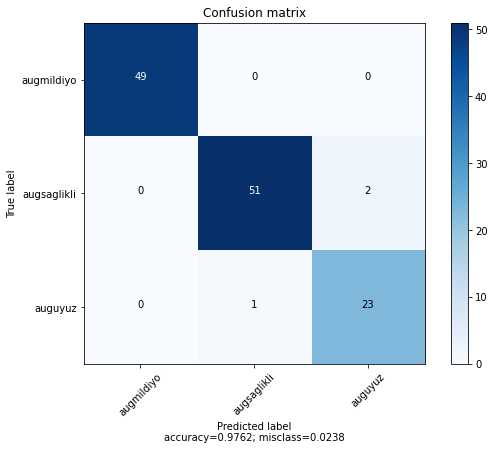

In [ ]:
from sklearn import metrics
plot_confusion_matrix(cm, target_names= ['augmildiyo', 'augsaglikli', 'auguyuz'], title='Confusion matrix' , normalize=False)

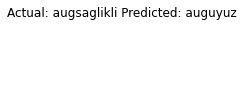

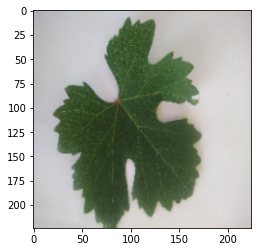

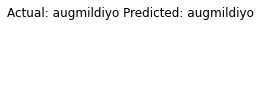

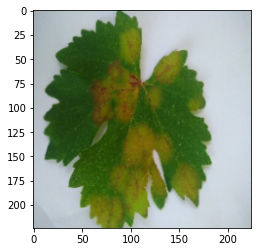

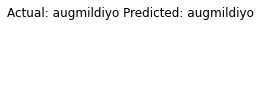

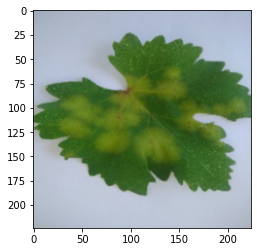

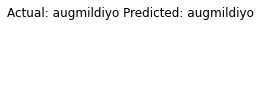

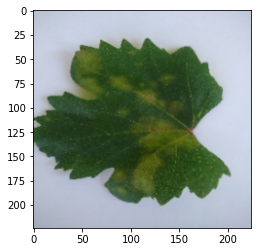

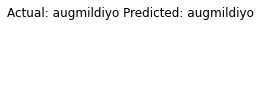

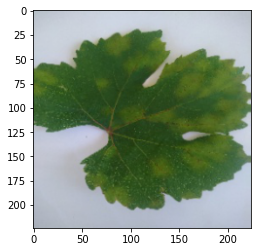

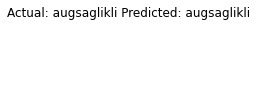

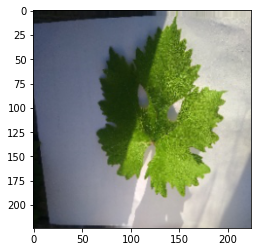

In [ ]:
visualize_model(base_model)
plt.show()

## New CNN model

In [ ]:
def CNN_Model(pretrained=True):
    #model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    #model = models.alexnet(pretrained=pretrained)
    #model = torch.hub.load('PingoLH/Pytorch-HarDNet', 'hardnet85', pretrained=True)
    #model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
    # or any of these variants
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
    #model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
    #num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    #model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    #model = model.to(device) # Transfer the Model to GPU if available
    #model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
    # or
    # model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')
    # or
    # model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x32d_wsl')
    # or
    #model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x48d_wsl')
    model.eval()
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1) # Learning Scheduler

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=100)

Epoch 1/100
----------


train:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
acc, cm = test_model(model,dataloaders,device)
print(cm)
print("Accuracy",acc)

sumfn [0, 0, 0]
fparray [0, 0, 0]
sumfp 0
sumfn 0
sumtp 126

Testset Accuracy(mean): 100.000000 %
- Recall :  100.0
- Precision:  100.0
- F1 Score:  100.0
[[49  0  0]
 [ 0 53  0]
 [ 0  0 24]]
Accuracy 1.0


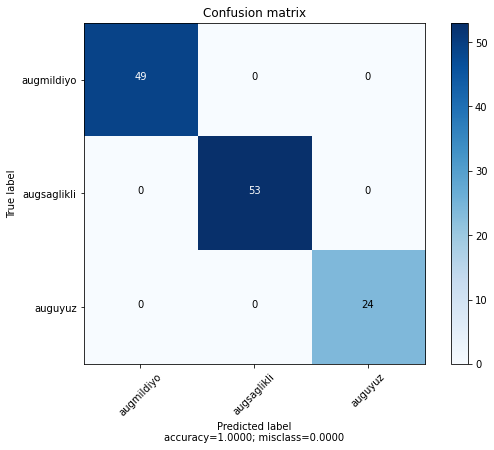

In [ ]:
from sklearn import metrics
plot_confusion_matrix(cm, target_names= ['augmildiyo', 'augsaglikli', 'auguyuz'], title='Confusion matrix' , normalize=False)

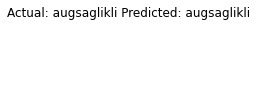

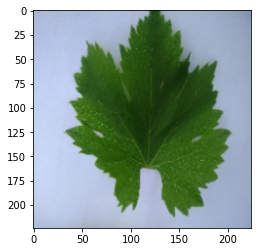

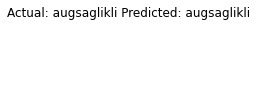

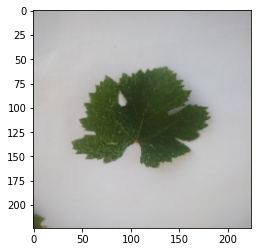

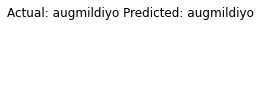

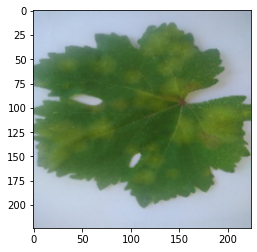

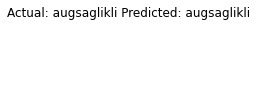

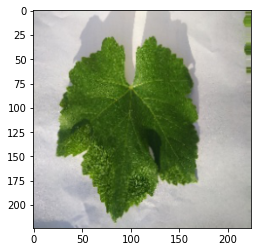

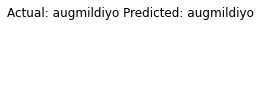

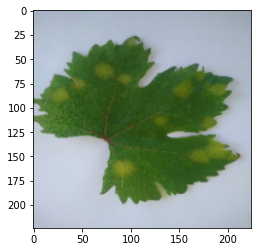

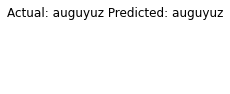

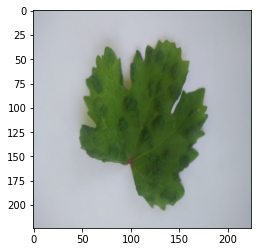

In [ ]:
visualize_model(base_model)
plt.show()

In [ ]:
def CNN_Model(pretrained=True):
    #model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    #model = models.alexnet(pretrained=pretrained)
    #model = torch.hub.load('PingoLH/Pytorch-HarDNet', 'hardnet85', pretrained=True)
    #model = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
    # or any of these variants
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet169', pretrained=True)
    #model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet201', pretrained=True)
    # model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet161', pretrained=True)
    #num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    #model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    #model = model.to(device) # Transfer the Model to GPU if available
    #model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
    # or
    # model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x16d_wsl')
    # or
    # model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x32d_wsl')
    # or
    #model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x48d_wsl')
    model.eval()
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=429, gamma=0.1) # Learning Scheduler

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth


  0%|          | 0.00/54.7M [00:00<?, ?B/s]

In [ ]:
model.cuda()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
np.seterr(divide='ignore', invalid='ignore')
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler,num_epochs=100)

KeyboardInterrupt: ignored